# Walk Forward: A Realistic Approach to Backtesting

![](<src/10_Table_Validation Methods.png>)

In [1]:
from modules import utils
utils.configure_plotly_template(showlegend=True)

## Load the data

In [2]:
import pandas as pd
df = pd.read_parquet('../../../data/EIA/electricity_demand_ciso_preprocessed.parquet')
df

subba,PGAE,SCE,SDGE,VEA
period,,,,
2018-12-31 16:00:00-08:00,10440.0,10287.0,2414.0,75.0
2018-12-31 17:00:00-08:00,11256.0,11039.0,2566.0,86.0
...,...,...,...,...
2025-05-10 23:00:00-07:00,12846.0,14642.0,2857.0,72.0
2025-05-11 00:00:00-07:00,12053.0,13502.0,2613.0,65.0


In [3]:
df = df.resample('D').sum().interpolate(method="linear")  # or df.dropna()

In [4]:
df = df[['SDGE']]
df.columns = ['values']

In [5]:
df = df.resample('D').sum().div(1_000_000)
df.plot()

In [6]:
df = df.loc['2019':'2023']
df

,values
period,
2019-01-01 00:00:00-08:00,0.048741
2019-01-02 00:00:00-08:00,0.054650
...,...
2023-12-30 00:00:00-08:00,0.048711
2023-12-31 00:00:00-08:00,0.048995


In [7]:
series = df['values']

In [8]:
series.plot()

In [9]:
from statsmodels.tsa.stattools import adfuller
adfuller(series)

(np.float64(-3.4040465028636775),
 np.float64(0.010821697658535138),
 23,
 1802,
 {'1%': np.float64(-3.4339840952648695),
  '5%': np.float64(-2.8631452508003057),
  '10%': np.float64(-2.567624583142913)},
 np.float64(-15986.835518269465))

In [10]:
df['values_diff'] = series.diff()

/var/folders/89/hqh4vvhn24q2xc8ph93krqz80000gn/T/ipykernel_90284/1226758537.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
adfuller(df['values_diff'].dropna())

(np.float64(-11.09635628207097),
 np.float64(3.964833363755291e-20),
 25,
 1799,
 {'1%': np.float64(-3.433990164137254),
  '5%': np.float64(-2.8631479299063405),
  '10%': np.float64(-2.567626009684832)},
 np.float64(-15971.598314655821))

In [12]:
df['values'].plot()

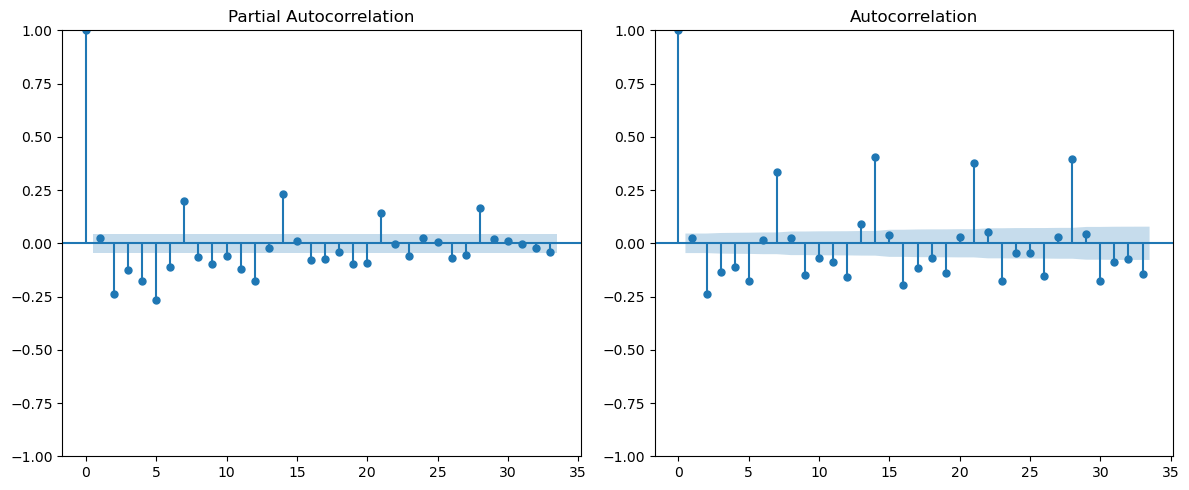

In [13]:
# acf and pacf side by side
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot_pacf(df['values_diff'].dropna(), ax=axes[0])
plot_acf(df['values_diff'].dropna(), ax=axes[1])
plt.tight_layout()
plt.show()

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['values'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            values   No. Observations:                 1826
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                8068.773
Date:                           Mon, 12 May 2025   AIC                         -16127.545
Time:                                   20:22:42   BIC                         -16100.018
Sample:                               01-01-2019   HQIC                        -16117.389
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4052      0.084      4.804      0.000       0.240       0.571
ma.L1         -0.5794      0.076     -7.581      0.000      -0.729      -0.430
ar.S.L7       -0.2840      0.023    -12.399      0.000      -0.329      -0.239
ma.S.L7       -0.7286      0.022    -33.876      0.000      -0.771      -0.686
sigma2      8.108e-06   2.24e-07     36.195      0.000    7.67e-06    8.55e-06
===================================================================================
Ljung-Box (L1) (Q):                  16.42   Jarque-Bera (JB):               154.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.04
Prob(H) (two-sided):                  0.72   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
forecast = results.forecast(steps=7 * 8).rename("forecast")
forecast

2024-01-01 00:00:00-08:00    0.053645
2024-01-02 00:00:00-08:00    0.053201
                               ...   
2024-02-24 00:00:00-08:00    0.051472
2024-02-25 00:00:00-08:00    0.050693
Freq: D, Name: forecast, Length: 56, dtype: float64

In [16]:
mask = df['values'].isna()
df[mask]

,values,values_diff
period,,


In [27]:
df['forecast'] = forecast
df

,values,values_diff,forecast
period,,,
2019-01-01 00:00:00-08:00,0.048741,NaN,NaN
2019-01-02 00:00:00-08:00,0.054650,0.005909,NaN
...,...,...,...
2023-12-30 00:00:00-08:00,0.048711,-0.000627,NaN
2023-12-31 00:00:00-08:00,0.048995,0.000284,NaN


In [ ]:
df = pd.concat([df, forecast], axis=1).sort_index()[['values', 'forecast']]

In [44]:
mask = df['values'].isna()
df[mask]

,values,forecast
2019-03-11 08:00:00+00:00,NaN,NaN
2019-03-12 08:00:00+00:00,NaN,NaN
...,...,...
2024-02-24 08:00:00+00:00,NaN,0.051472
2024-02-25 08:00:00+00:00,NaN,0.050693


In [28]:

df_forecast = df.copy()
df_forecast = pd.concat([df_forecast, forecast]).sort_index()
df_forecast

,values,values_diff,forecast
2019-01-01 00:00:00-08:00,0.048741,NaN,NaN
2019-01-02 00:00:00-08:00,0.054650,0.005909,NaN
...,...,...,...
2024-02-24 00:00:00-08:00,NaN,NaN,0.051472
2024-02-25 00:00:00-08:00,NaN,NaN,0.050693


In [29]:
df_forecast[['values', 'forecast']].plot()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

## Walk Forward Validation

### How `TimeSeriesSplit` works

In [2]:
from sklearn.model_selection import TimeSeriesSplit

In [3]:
ts = TimeSeriesSplit(test_size=200)

In [4]:
splits = ts.split(X=df)

In [5]:
split1= next(splits)

In [6]:
split1

(array([    0,     1,     2, ..., 25301, 25302, 25303], shape=(25304,)),
 array([25304, 25305, 25306, 25307, 25308, 25309, 25310, 25311, 25312,
        25313, 25314, 25315, 25316, 25317, 25318, 25319, 25320, 25321,
        25322, 25323, 25324, 25325, 25326, 25327, 25328, 25329, 25330,
        25331, 25332, 25333, 25334, 25335, 25336, 25337, 25338, 25339,
        25340, 25341, 25342, 25343, 25344, 25345, 25346, 25347, 25348,
        25349, 25350, 25351, 25352, 25353, 25354, 25355, 25356, 25357,
        25358, 25359, 25360, 25361, 25362, 25363, 25364, 25365, 25366,
        25367, 25368, 25369, 25370, 25371, 25372, 25373, 25374, 25375,
        25376, 25377, 25378, 25379, 25380, 25381, 25382, 25383, 25384,
        25385, 25386, 25387, 25388, 25389, 25390, 25391, 25392, 25393,
        25394, 25395, 25396, 25397, 25398, 25399, 25400, 25401, 25402,
        25403, 25404, 25405, 25406, 25407, 25408, 25409, 25410, 25411,
        25412, 25413, 25414, 25415, 25416, 25417, 25418, 25419, 25420,
    

In [7]:
split2= next(splits)

In [8]:
split2

(array([    0,     1,     2, ..., 25501, 25502, 25503], shape=(25504,)),
 array([25504, 25505, 25506, 25507, 25508, 25509, 25510, 25511, 25512,
        25513, 25514, 25515, 25516, 25517, 25518, 25519, 25520, 25521,
        25522, 25523, 25524, 25525, 25526, 25527, 25528, 25529, 25530,
        25531, 25532, 25533, 25534, 25535, 25536, 25537, 25538, 25539,
        25540, 25541, 25542, 25543, 25544, 25545, 25546, 25547, 25548,
        25549, 25550, 25551, 25552, 25553, 25554, 25555, 25556, 25557,
        25558, 25559, 25560, 25561, 25562, 25563, 25564, 25565, 25566,
        25567, 25568, 25569, 25570, 25571, 25572, 25573, 25574, 25575,
        25576, 25577, 25578, 25579, 25580, 25581, 25582, 25583, 25584,
        25585, 25586, 25587, 25588, 25589, 25590, 25591, 25592, 25593,
        25594, 25595, 25596, 25597, 25598, 25599, 25600, 25601, 25602,
        25603, 25604, 25605, 25606, 25607, 25608, 25609, 25610, 25611,
        25612, 25613, 25614, 25615, 25616, 25617, 25618, 25619, 25620,
    

In [9]:
list_df_train = []
list_df_test = []

for index_train, index_test in ts.split(df):
    list_df_train.append(df.iloc[index_train])
    list_df_test.append(df.iloc[index_test])

In [10]:
list_df_train[0]

,energy_kw
2012-01-01 00:00:00+00:00,416921.975284
2012-01-01 01:00:00+00:00,450201.475472
...,...
2014-11-20 06:00:00+00:00,581826.494358
2014-11-20 07:00:00+00:00,630738.185610


In [11]:
list_df_test[0]

,energy_kw
2014-11-20 08:00:00+00:00,680824.478606
2014-11-20 09:00:00+00:00,848291.571711
...,...
2014-11-28 14:00:00+00:00,957499.471411
2014-11-28 15:00:00+00:00,969648.491951


In [12]:
list_df_train[1]

,energy_kw
2012-01-01 00:00:00+00:00,416921.975284
2012-01-01 01:00:00+00:00,450201.475472
...,...
2014-11-28 14:00:00+00:00,957499.471411
2014-11-28 15:00:00+00:00,969648.491951


In [13]:
list_df_test[1]

,energy_kw
2014-11-28 16:00:00+00:00,9.753103e+05
2014-11-28 17:00:00+00:00,1.020760e+06
...,...
2014-12-06 22:00:00+00:00,8.752036e+05
2014-12-06 23:00:00+00:00,7.135173e+05


## Machine Learning Model

### Separate the data

1. Target: which variable do you want to predict?
2. Explanatory: which variables will you use to calculate the prediction?

In [15]:
l_series_train = []
l_series_test = []

for index_train, index_test in ts.split(df):
    series_train = df.iloc[index_train]
    series_test = df.iloc[index_test]
    
    l_series_train.append(series_train)
    l_series_test.append(series_test)

### Simulate one computation of the ML model

- Compute the model
- Calculate predictions on the test set
- Evaluate how good the model is

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

model_dt = DecisionTreeRegressor(max_depth=15, random_state=42)
model_dt.fit(X_train, y_train)

y_pred = model_dt.predict(X_test)
error_mse = mean_squared_error(y_test, y_pred)
error_mse

5.308276780150754

### Add the procedure inside the for loop

In [17]:
model_dt = DecisionTreeRegressor(max_depth=15, random_state=42)

error_mse_list = []

for index_train, index_test in ts.split(df):
    X_train, y_train = X.iloc[index_train], y.iloc[index_train]
    X_test, y_test = X.iloc[index_test], y.iloc[index_test]
    
    model_dt.fit(X_train, y_train)
    
    y_pred = model_dt.predict(X_test)
    error_mse = mean_squared_error(y_test, y_pred)
    
    error_mse_list.append(error_mse)

In [18]:
error_mse_list

[9.37728476681153,
 11.360255478508225,
 33.52405207745693,
 7.342669459500167,
 5.308276780150754]

In [19]:
import  numpy as np

In [20]:
np.mean(error_mse_list)

13.38250771248552

## Anchored Walk Forward evaluation in backtesting

![](<src/10_Table_Validation Methods.png>)

### Create a new strategy

In [21]:
from backtesting import Backtest, Strategy

In [22]:
df

,Open,High,Low,Close,Volume,change_tomorrow
Date,,,,,,
2016-12-08,56.325228,56.582507,55.902560,56.058762,21220800,1.549143
2016-12-09,56.214968,56.959234,56.169027,56.940857,27349400,0.321692
...,...,...,...,...,...,...
2023-03-14,256.750000,261.070007,255.860001,260.790009,33620300,1.751806
2023-03-15,259.980011,266.480011,259.209991,265.440002,46028000,3.895731


In [ ]:
bt = Backtest(df, ???, cash=10000, commission=.002, exclusive_orders=True)

In [26]:
class Regression(Strategy):
    limit_buy = 1
    limit_sell = -5
    
    n_train = 600
    coef_retrain = 200
    
    def init(self):
        self.model = DecisionTreeRegressor(max_depth=15, random_state=42)
        self.already_bought = False
        
        X_train = self.data.df.iloc[:self.n_train, :-1]
        y_train = self.data.df.iloc[:self.n_train, -1]
        
        self.model.fit(X=X_train, y=y_train)

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :-1]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

In [27]:
class WalkForwardAnchored(Regression):
    def next(self):
        
        # we don't take any action and move on to the following day
        if len(self.data) < self.n_train:
            return
        
        # we retrain the model each 200 days
        if len(self.data) % self.coef_retrain == 0:
            X_train = self.data.df.iloc[:, :-1]
            y_train = self.data.df.iloc[:, -1]

            self.model.fit(X_train, y_train)

            super().next()
            
        else:
            
            super().next()

In [28]:
from backtesting import Backtest
bt = Backtest(df, WalkForwardAnchored, cash=10000, commission=.002, exclusive_orders=True)

In [29]:
import multiprocessing as mp
mp.set_start_method('fork')

In [31]:
stats_skopt, heatmap, optimize_result = bt.optimize(
    limit_buy = range(0, 6), limit_sell = range(-6, 0),
    maximize='Return [%]',
    max_tries=500,
    random_state=42,
    return_heatmap=True,
    return_optimization=True,
    method='skopt'
    )

dff = heatmap.reset_index()
dff = dff.sort_values('Return [%]', ascending=False)
dff

,limit_buy,limit_sell,Return [%]
20,4,-1,36.666346
19,4,-2,36.666346
...,...,...,...
12,2,-1,-60.946987
11,2,-3,-61.384028


## Unanchored Walk Forward

### Create a library of strategies

### Create the unanchored walk forward class

![](<src/10_Table_Validation Methods.png>)

### Import the strategy and perform the backtest

In [34]:
%load_ext autoreload
%autoreload 2

In [36]:
import strategies

In [37]:
strategies.WalkForwardUnanchored

strategies.WalkForwardUnanchored

In [38]:
bt_unanchored = Backtest(df, strategies.WalkForwardUnanchored, cash=10000, commission=.002, exclusive_orders=True)

stats_skopt, heatmap, optimize_result = bt_unanchored.optimize(
    limit_buy = range(0, 6), limit_sell = range(-6, 0),
    maximize='Return [%]',
    max_tries=500,
    random_state=42,
    return_heatmap=True,
    return_optimization=True,
    method='skopt'
    )

dff = heatmap.reset_index()
dff = dff.sort_values('Return [%]', ascending=False)
dff

,limit_buy,limit_sell,Return [%]
7,2,-6,46.134435
0,0,-6,37.798327
...,...,...,...
13,3,-5,-86.571062
14,3,-4,-86.836675


### Interpret the strategies' performance

In [39]:
bt.plot(filename='reports_backtesting/walk_forward_anchored.html')

Row(id='3445', ...)

In [40]:
bt_unanchored.plot(filename='reports_backtesting/walk_forward_unanchored.html')

Row(id='4465', ...)

## Practice to master the knowledge

Work on the challenge with another dataset:

1. Learn the <a>mental models</a> to solve the challenge faster.
2. Complete the <a href="10D_Walk Forward Regression.ipynb">notebook</a>.